<a href="https://colab.research.google.com/github/spe301/Wikipedia-Capstone/blob/main/Discriminator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview

Wikipedia, as the name implies, is the Encyclopedia of the 21st century! It is an amazing place full of free information mantained by a community of volenteer editors. It has assisted in the removal of barriers when it comes to giving and receiving knwoledge. Unfortunatley, with this great democritization comes the potential spread of misinformation and plagarized content. With the rise of complex transformer models such as GPT2, AI can generate persuasive content that is practically identical to human written text.
See what I mean!: https://techcrunch.com/2019/02/17/openai-text-generator-dangerous/

This is where machine learning can help! We can train a Machine learning model to classify whether or not a body of text has been written by a human or an AI and use other NLP strategies to catch plagarism. If this seems like a problem you care about then keep reading!

* Spencer Holley
* aacjpw@gmail.com
* https://github.com/spe301/Wikipedia-Capstone

## Use cases

* wikipedia users and contributers can flag AI generated articles
* prevent AI generated fake news from spreading
* teachers and professors can flag AI generated essays 

## Potosnail Library

learn more at https://github.com/spe301/Potosnail

In [1]:
!pip install Potosnail==0.0.5

In [37]:
from potosnail import MachineLearning, DeepLearning, DataHelper, Evaluater
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

def ModelReadyString(text_str, pad):
  '''converts an individual unit of text into tokenized sequences'''
  text = [text_str]
  t = Tokenizer()
  t.fit_on_texts(text)
  tokens = t.texts_to_sequences(text)
  tokens2 = pad_sequences(tokens, maxlen=pad)
  return tokens2

ml = MachineLearning()
dl = DeepLearning()
dh = DataHelper()
ev = Evaluater()

## Obtain Data

We will concatenate the 180 generated articles with 180 randomly selected real articles

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/spe301/Wikipedia-Capstone/main/Data/HumanText.csv').drop(['Unnamed: 0', 'Unnamed: 0.1'], axis='columns')
df2 = pd.read_csv('drive/MyDrive/Generated.csv').drop(['Unnamed: 0'], axis='columns')
data = pd.concat([df.sample(n=180), df2])
data

,Text,Human,AI
652,"shanghai , it is the most populous urban are...",1,0
78,elisabeth dee devos she was republican nation...,1,0
366,john christopher depp ii he is the tenth high...,1,0
370,kale kale originates from northern middle engl...,1,0
580,psychiatry is the medical specialty devoted to...,1,0
...,...,...,...
175,by jonathan rosen\n\njonathan rosen is a senio...,0,1
176,he was able to maintain good relations with t...,0,1
177,mealworms are shed during the larval phase of ...,0,1
178,"by\n\nby 2015, syrian president muammar gaddaf...",0,1


## Data Preproccessing 

In [4]:
avg = 0
for i in range(len(data['Text'])):
  avg += len(list(data['Text'])[i].split(' '))/len(data)

pad = int(avg)
pad

1828

In [5]:
train, test = dh.HoldOut(data)

In [6]:
text, lables = dl.ModelReadyText1(train['Text'], train['AI'], pad)
Xtest, ytest = dl.ModelReadyText1(test['Text'], test['AI'], pad)

In [7]:
import numpy as np

words = []
for i in range(len(train)):
  word_lst = list(train['Text'])[i].replace('\n', ' ').split(' ')
  for word in word_lst:
    words.append(word.replace('.', '').replace(',', '').replace(' ', '').replace('"', '').replace(':', '').replace(';', '').replace('!', ''))

vocab = len(np.unique(words))
vocab

45359

# Modeling

## RNN Gridsearch

In [8]:
params = {'output_dim': [2], 'embedding': [vocab], 'nodes': [32, 64], 'activation': ['relu', 'tanh'], 'regularizer': ['L1'], 
          'stacking': [False], 'dropout': [False], 'optimizer': ['adam', 'rmsprop'], 'method': ['LSTM', 'GRU'], 'bidirectional': [True, False]}
grid = dl.TestDL(params, dl.RNN, 'classification', text, lables, batch_size=64)

Streaming output truncated to the last 5000 lines.
Epoch 24/50
3/3 [==============================] - 1s 201ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.4053 - val_accuracy: 0.8409
Epoch 25/50
3/3 [==============================] - 1s 201ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.3177 - val_accuracy: 0.8636
Epoch 26/50
3/3 [==============================] - 1s 201ms/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.3440 - val_accuracy: 0.8636
Epoch 27/50
3/3 [==============================] - 1s 195ms/step - loss: 0.0107 - accuracy: 1.0000 - val_loss: 0.3715 - val_accuracy: 0.8182
Epoch 28/50
4/4 [==============================] - 1s 58ms/step - loss: 0.6204 - accuracy: 0.7315
Epoch 1/50
3/3 [==============================] - 5s 565ms/step - loss: 0.6911 - accuracy: 0.5358 - val_loss: 0.6760 - val_accuracy: 0.6136
Epoch 2/50
3/3 [==============================] - 1s 357ms/step - loss: 0.6716 - accuracy: 0.7606 - val_loss: 0.6409 - val_accuracy: 0.8182
Epoch 3

## Evaluation of best model with potosnail

In [9]:
grid.best_estimator_.model.save('drive/MyDrive/model.h5')

In [10]:
grid.best_params_

{'activation': 'tanh',
 'bidirectional': True,
 'dropout': False,
 'embedding': 45359,
 'method': 'GRU',
 'nodes': 32,
 'optimizer': 'adam',
 'output_dim': 2,
 'regularizer': 'L1',
 'stacking': False}

In [13]:
X, y = dl.ModelReadyText1(test['Text'], test['AI'], pad)
grid.best_estimator_.score(X, y)

2/2 [==============================] - 1s 47ms/step - loss: 1.2646 - accuracy: 0.6389


0.6388888955116272

In [14]:
grid.best_estimator_.score(text, lables)

11/11 [==============================] - 1s 53ms/step - loss: 0.2432 - accuracy: 0.9321


0.9320987462997437

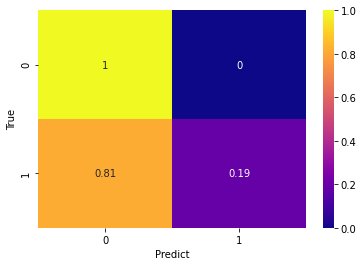

In [18]:
#model.predict(Xtest)
from tensorflow.keras import models

model = models.load_model('drive/MyDrive/model.h5')
ev.BuildConfusionDL(model, X, y)

## The best Model before Potosnail

In [19]:
model2 = models.load_model('drive/MyDrive/BidFinal.h5')

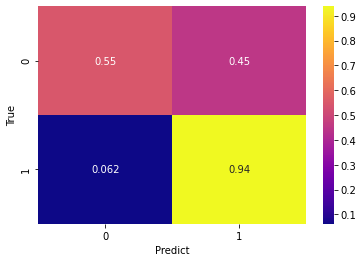

In [20]:
ev.BuildConfusionDL(model2, X, y)

## Going further with BidFinal

I am going with this one because there was a better TPR (True Positive Rate).

In [23]:
model2.evaluate(X, y)

2/2 [==============================] - 0s 47ms/step - loss: 0.5833 - accuracy: 0.7222


[0.5832929611206055, 0.7222222089767456]

In [25]:
model.evaluate(X, y)

2/2 [==============================] - 1s 48ms/step - loss: 1.2646 - accuracy: 0.6389


[1.2646055221557617, 0.6388888955116272]

In [24]:
model2.evaluate(text, lables)

11/11 [==============================] - 1s 55ms/step - loss: 0.4170 - accuracy: 0.8333


[0.41697683930397034, 0.8333333134651184]

In [26]:
model.evaluate(text, lables)

11/11 [==============================] - 1s 54ms/step - loss: 0.2432 - accuracy: 0.9321


[0.24318937957286835, 0.9320987462997437]

In [ ]:
test.reset_index(inplace=True)

Testing the model on a random article

In [64]:
sample = test.iloc[np.random.randint(35)]
truth = sample['AI']
text_str = sample['Text']
output = model.predict(ModelReadyString(text_str, pad))
output2 = model2.predict(ModelReadyString(text_str, pad))
print('model predicts a {}% probability that an AI wrote this.'.format(round(output[0][1]*100, 2)))
print('model2 predicts a {}% probability that an AI wrote this.'.format(round(output2[0][1]*100, 2)))

model predicts a 92.83% probability that an AI wrote this.
model2 predicts a 97.18% probability that an AI wrote this.


In [65]:
sample

Text     2008 was a straight arrow for the city. the ce...
Human                                                    0
AI                                                       1
Name: 132, dtype: object

In [66]:
text_str

'2008 was a straight arrow for the city. the census counted a total population of 5,515,276. this was an increase of 10,829, or 2.8% from the estimated population of 5,514,286 in 2007. the overall population increased by 1.7%. there were 1,331,059 foreign-born residents, 1,824,718 residents were born overseas, and 1,084,707 people were born in new york county. the racial makeup of the city was 48.4% white, 40.8% black, 10.6% hispanic, 3.4% asian, 0.5% pacific islander, 2.3% hispanics, and 0.3% non-hispanic white. hispanics made up the largest percentage of the citys population, making up 40.6% of the population, or 2,090,922, or 3.2% of the citys total population. hispanics make up the largest percentage of african-american population in the united states, making up 34.7% of the citys population. more than half of the citys population  the african-american population in new york is the second-largest by total population after newly gentrified inner city neighborhoods. the african-ameri

## Text EDA

1. What would a wordcloud look like for these two seperate collections of text?

insight: first was a major word for both the AI written and Human written articles because the articles often mention that the topic was or is the first to do or be something in particular. United States and german were major in the AI written text because there were many political articles whereas the real articles used terms more general words, like may and many, because they were over a wider variety of topics

In [67]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

AI = ','.join(data.loc[data['AI']==1]['Text'])
Human = ','.join(df['Text'])

In [68]:
AiCloud = WordCloud(max_words=50, stopwords=STOPWORDS, background_color='white').generate(AI)
HumanCloud = WordCloud(max_words=50, stopwords=STOPWORDS, background_color='white').generate(Human)

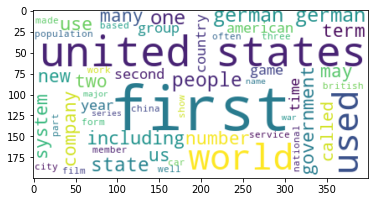

In [71]:
from matplotlib import pyplot as plt

plt.imshow(AiCloud, interpolation='bilinear')

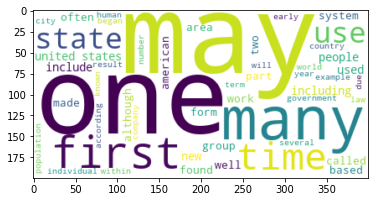

In [73]:
plt.imshow(HumanCloud, interpolation='bilinear')

2. What percentage of AI generated text is stopwords compared to the human written text?

insight: both have very little stopwords but the real articles have a slightly lower use of stopwords at 0.39% compared to 0.44%

In [74]:
AiWords = AI.split(' ')
HumanWords = Human.split(' ')
AiStoppers = 0
for word in AiWords:
  if word in list(STOPWORDS):
    AiStoppers += 1

HumanStoppers = 0
for word in HumanWords:
  if word in list(STOPWORDS):
    HumanStoppers += 1

print('the AI written text is {}% stopwords and the Human written text is {}% stopwords'.format(round(AiStoppers/len(AiWords), 2), round(HumanStoppers/len(HumanWords), 2)))

the AI written text is 0.44% stopwords and the Human written text is 0.39% stopwords
